In [428]:
import pandas as pd
import numpy as np 

In [429]:
book = pd.read_csv('Book reviews/BX_Books.csv', encoding='latin-1', sep=';')
rating = pd.read_csv('Book reviews/BX-Book-Ratings.csv', encoding='latin-1', sep=';')
user = pd.read_csv('Book reviews/BX-Users.csv', encoding='latin-1', sep=';')
genre_df=pd.read_csv('Book reviews/Goodreads_books_with_genres.csv', encoding='latin-1', sep=',',on_bad_lines='skip',usecols=['Title','isbn', 'genres'])

# data cleaning (rating et genre) + merge des genres avec rating

In [430]:
# sélection des livres avec plus de 50 notes et des utilisateurs ayant noté au moins 5 livres
counts1 = rating['User-ID'].value_counts()
rating = rating[rating['User-ID'].isin(counts1[counts1 >= 5].index)]
counts = rating['Book-Rating'].value_counts()
rating = rating[rating['Book-Rating'].isin(counts[counts >= 50].index)]

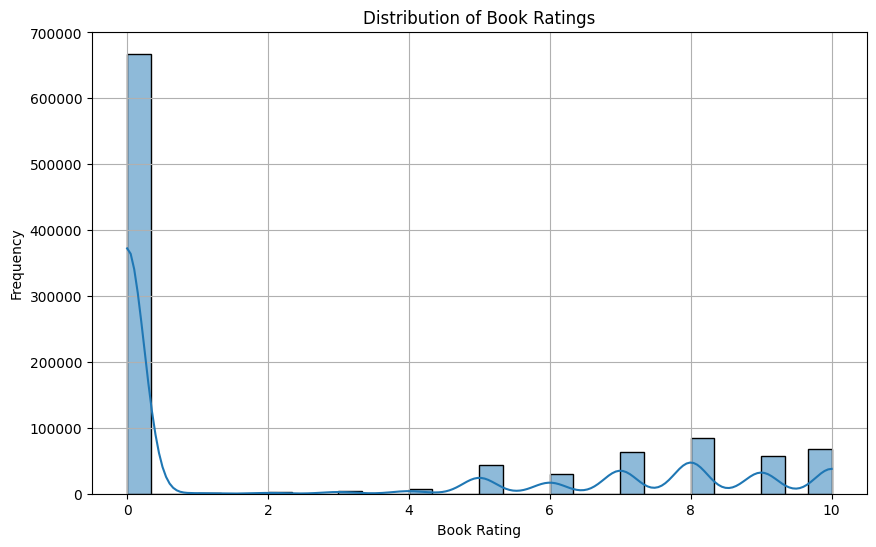

In [431]:
# distribution de chaque colonne
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

def plot_distribution(data, column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

plot_distribution(rating, 'Book-Rating', 'Distribution of Book Ratings', 'Book Rating', 'Frequency')

In [432]:
## Remplacement des 0 par la moyenne des notes associés a chaque groupe d'âge du livre
## afin de ne pas les supprimer et avoir des notes reflettant la réalité

# Étape 1 : tranches d'âge réalistes
def get_age_group(age):
    if pd.isna(age) or age < 0 or age > 120:
        return 'unknown'
    elif age <= 12:
        return 'Enfant 1-12'
    elif age <= 17:
        return 'Adolescent 12-17'
    elif age <= 25:
        return 'Jeune adulte 18-25'
    elif age <= 35:
        return 'Adulte 26-35'
    elif age <= 50:
        return 'Adulte 36-50'
    else:
        return 'Senior 50+'

user['AgeGroup'] = user['Age'].apply(get_age_group)
user = user[user['AgeGroup'] != 'unknown']  # on garde que les âges valides

# fusion rating + âge
rating_merged = rating.merge(user[['User-ID', 'AgeGroup']], on='User-ID', how='inner')

# Séparer vraies notes et notes à 0
real_ratings = rating_merged[rating_merged['Book-Rating'] > 0]
missing_ratings = rating_merged[rating_merged['Book-Rating'] == 0]

# moyenne PAR ISBN + groupe D’ÂGE, avec minimum de votes requis (ex: ≥5)
grouped = real_ratings.groupby(['ISBN', 'AgeGroup'])['Book-Rating'].agg(['mean', 'count']).reset_index()
grouped = grouped[grouped['count'] >= 5]  # ← paramétrable
grouped.rename(columns={'mean': 'GroupMean'}, inplace=True)

# fusion et remplacement
filled = missing_ratings.merge(grouped[['ISBN', 'AgeGroup', 'GroupMean']], on=['ISBN', 'AgeGroup'], how='left')

# Conserver seulement ceux qu’on peut remplacer (les autres seront supprimés)
filled = filled[filled['GroupMean'].notna()]
filled['Book-Rating'] = filled['GroupMean'].round().astype(int)
filled = filled[rating.columns]  # format original

# concat avec vraies notes
rating_final = pd.concat([real_ratings[rating.columns], filled])
rating_final = rating_final.sort_values(by=['User-ID', 'ISBN']).reset_index(drop=True)

# Résumé
n_initial = rating.shape[0]
n_retained = rating_final.shape[0]
print(f" Notes finales conservées : {n_retained} / {n_initial} ({(n_retained/n_initial)*100:.1f}%)")

 Notes finales conservées : 335947 / 1028948 (32.6%)


##### on remarque que ca a supprimé les 0 car ils ne sont pas emputables par une moyenne du groupe

In [433]:
# Séparer les genres : créer deux colonnes -> principal + secondaires
def split_genres(genre_str):
    if pd.isna(genre_str):
        return pd.Series(["Inconnu", ""])
    genres = [g.strip() for g in genre_str.replace(';', ',').split(',') if g.strip()]
    if not genres:
        return pd.Series(["Inconnu", ""])
    return pd.Series([genres[0], ', '.join(genres[1:])])

genre_df[['Genre Principal', 'Genres Secondaires']] = genre_df['genres'].apply(split_genres)

# Aperçu du résultat
print(genre_df[['Title', 'Genre Principal', 'Genres Secondaires']].head())

                                               Title Genre Principal  \
0  Harry Potter and the Half-Blood Prince (Harry ...         Fantasy   
1  Harry Potter and the Order of the Phoenix (Har...         Fantasy   
2  Harry Potter and the Chamber of Secrets (Harry...         Fantasy   
3  Harry Potter and the Prisoner of Azkaban (Harr...         Fantasy   
4  Harry Potter Boxed Set  Books 1-5 (Harry Potte...         Fantasy   

                                  Genres Secondaires  
0  Young Adult, Fiction, Fantasy, Magic, Children...  
1  Young Adult, Fiction, Fantasy, Magic, Children...  
2  Fiction, Young Adult, Fantasy, Magic, Children...  
3  Fiction, Young Adult, Fantasy, Magic, Children...  
4  Young Adult, Fiction, Fantasy, Magic, Adventur...  


# fusion de toutes les tables

In [434]:
# Fusion des tables
books_ratings = pd.merge(book,rating_final, on="ISBN", how="inner")
book_match = pd.merge(books_ratings, user, on="User-ID", how="inner").merge(genre_df, left_on="ISBN",right_on='isbn', how="inner")

In [435]:
book_match.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Location', 'Age', 'AgeGroup', 'Title', 'isbn', 'genres',
       'Genre Principal', 'Genres Secondaires'],
      dtype='object')

# data cleaning du dataset merge final 

In [436]:
book_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22461 entries, 0 to 22460
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 22461 non-null  object 
 1   Book-Title           22461 non-null  object 
 2   Book-Author          22461 non-null  object 
 3   Year-Of-Publication  22461 non-null  int64  
 4   Publisher            22461 non-null  object 
 5   Image-URL-S          22461 non-null  object 
 6   Image-URL-M          22461 non-null  object 
 7   Image-URL-L          22461 non-null  object 
 8   User-ID              22461 non-null  int64  
 9   Book-Rating          22461 non-null  int64  
 10  Location             22461 non-null  object 
 11  Age                  22461 non-null  float64
 12  AgeGroup             22461 non-null  object 
 13  Title                22461 non-null  object 
 14  isbn                 22461 non-null  object 
 15  genres               22460 non-null 

In [437]:
book_match.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ISBN,22461,2458,0142001740,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Book-Title,22461,2435,The Secret Life of Bees,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Book-Author,22461,1391,James Patterson,749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year-Of-Publication,22461.0,NaN,NaN,NaN,1985.513112,161.23071,0.0,1997.0,2000.0,2002.0,2004.0
Publisher,22461,488,Perennial,1264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Image-URL-S,22461,2458,http://images.amazon.com/images/P/0142001740.0...,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Image-URL-M,22461,2458,http://images.amazon.com/images/P/0142001740.0...,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Image-URL-L,22461,2458,http://images.amazon.com/images/P/0142001740.0...,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User-ID,22461.0,NaN,NaN,NaN,140151.338765,79234.022875,99.0,74286.0,138407.0,208410.0,278843.0
Book-Rating,22461.0,NaN,NaN,NaN,7.912337,1.390023,1.0,7.0,8.0,9.0,10.0


In [438]:
book_match['Year-Of-Publication'].unique()

array([1999, 2000, 1994, 1987, 1995, 2003, 1998, 2001, 1996, 1991, 2004,
       2002, 1992, 1989, 1993, 1997,    0, 1990, 1982, 1983, 1988, 1950,
       1970, 1978, 1984, 1985, 1986, 1963, 1977, 1972, 1976, 1981, 1948,
       1980, 1958, 1956, 1954, 1964, 1979, 1969, 1965, 1962, 1966, 1971,
       1975, 1974, 1973, 1957, 1960, 1955, 1953, 1949, 1961])

In [439]:
# Convertir en numérique, erreurs forcées à NaN
book_match['Year-Of-Publication'] = pd.to_numeric(book_match['Year-Of-Publication'], errors='coerce')

# Filtrer les années valides entre 1450 et 2025
book_match.loc[~book_match['Year-Of-Publication'].between(1450, 2025), 'Year-Of-Publication'] = np.nan

# Optionnel : afficher les années valides restantes
print(book_match['Year-Of-Publication'].dropna().unique())

# Convertir les années en date 
book_match['Year-Of-Publication'] = pd.to_datetime(book_match['Year-Of-Publication'], format='%Y', errors='coerce')


[1999. 2000. 1994. 1987. 1995. 2003. 1998. 2001. 1996. 1991. 2004. 2002.
 1992. 1989. 1993. 1997. 1990. 1982. 1983. 1988. 1950. 1970. 1978. 1984.
 1985. 1986. 1963. 1977. 1972. 1976. 1981. 1948. 1980. 1958. 1956. 1954.
 1964. 1979. 1969. 1965. 1962. 1966. 1971. 1975. 1974. 1973. 1957. 1960.
 1955. 1953. 1949. 1961.]


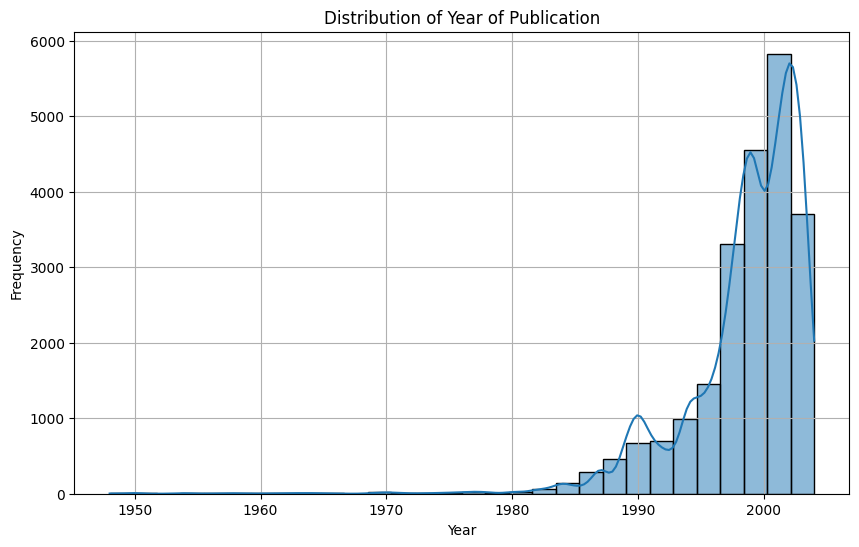

In [440]:
plot_distribution(book_match, 'Year-Of-Publication', 'Distribution of Year of Publication', 'Year', 'Frequency')

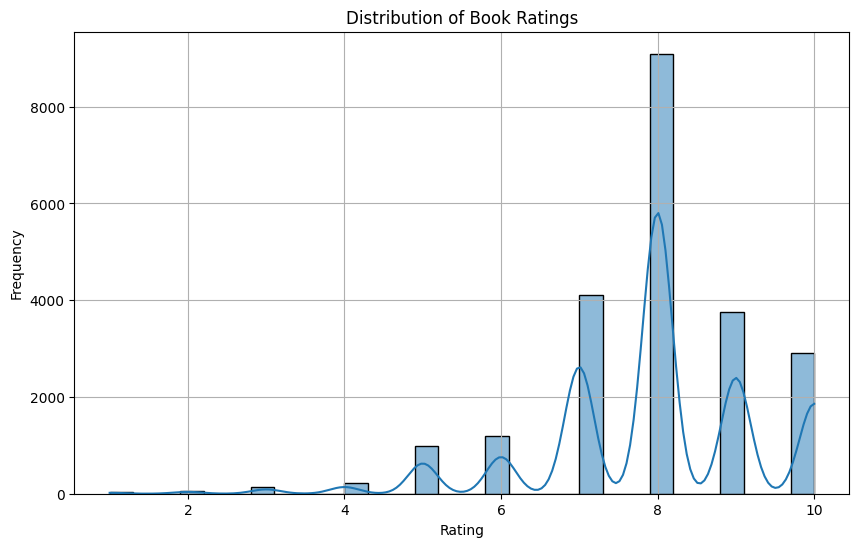

In [441]:
plot_distribution(book_match, 'Book-Rating', 'Distribution of Book Ratings', 'Rating', 'Frequency')

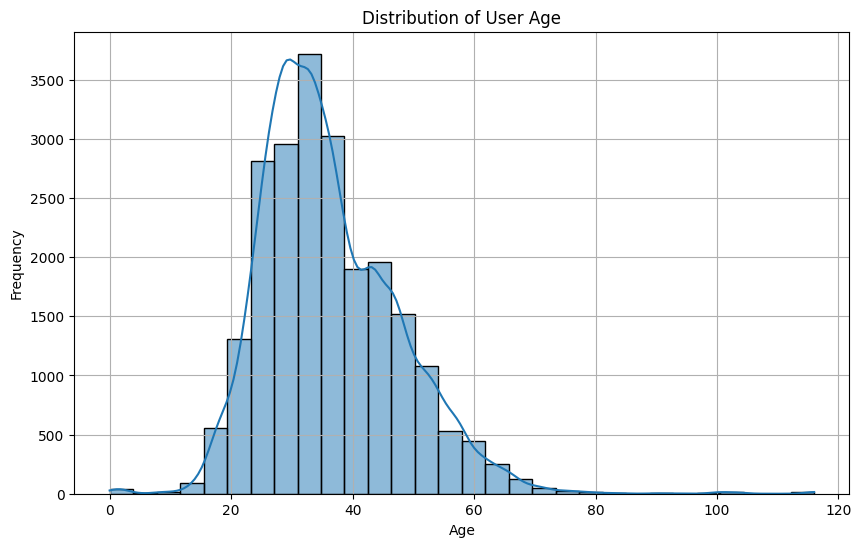

In [442]:
plot_distribution(book_match, 'Age', 'Distribution of User Age', 'Age', 'Frequency')

In [443]:
book_match.isnull().sum()

ISBN                     0
Book-Title               0
Book-Author              0
Year-Of-Publication    147
Publisher                0
Image-URL-S              0
Image-URL-M              0
Image-URL-L              0
User-ID                  0
Book-Rating              0
Location                 0
Age                      0
AgeGroup                 0
Title                    0
isbn                     0
genres                   1
Genre Principal          0
Genres Secondaires       0
dtype: int64

In [444]:
# supprression des lignes l'age manquant
book_match = book_match.dropna(subset=['Age'])

In [445]:
book_match.isnull().sum()

ISBN                     0
Book-Title               0
Book-Author              0
Year-Of-Publication    147
Publisher                0
Image-URL-S              0
Image-URL-M              0
Image-URL-L              0
User-ID                  0
Book-Rating              0
Location                 0
Age                      0
AgeGroup                 0
Title                    0
isbn                     0
genres                   1
Genre Principal          0
Genres Secondaires       0
dtype: int64

In [446]:
book_match['Book-Title'].nunique()

2435

In [447]:
book_match['Genre Principal'].isna().sum()

np.int64(0)

In [448]:
book_match.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Location', 'Age', 'AgeGroup', 'Title', 'isbn', 'genres',
       'Genre Principal', 'Genres Secondaires'],
      dtype='object')

In [449]:
book_match.AgeGroup.unique()

array(['Adulte 26-35', 'Jeune adulte 18-25', 'Adulte 36-50', 'Senior 50+',
       'Adolescent 12-17', 'Enfant 1-12'], dtype=object)

# sélection des colonnes utile

In [450]:
book_match.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Location', 'Age', 'AgeGroup', 'Title', 'isbn', 'genres',
       'Genre Principal', 'Genres Secondaires'],
      dtype='object')

In [451]:
book_match=book_match[[
    'ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
    'User-ID', 'Book-Rating', 'Age','AgeGroup', 'Genre Principal', 'Genres Secondaires',
    'Image-URL-L'
]]

In [452]:
book_match

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,AgeGroup,Genre Principal,Genres Secondaires,Image-URL-L
0,0440234743,The Testament,John Grisham,1999-01-01,Dell,388,8,35.0,Adulte 26-35,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...
1,0440234743,The Testament,John Grisham,1999-01-01,Dell,2977,7,25.0,Jeune adulte 18-25,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...
2,0440234743,The Testament,John Grisham,1999-01-01,Dell,3363,8,29.0,Adulte 26-35,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...
3,0440234743,The Testament,John Grisham,1999-01-01,Dell,7346,9,49.0,Adulte 36-50,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...
4,0440234743,The Testament,John Grisham,1999-01-01,Dell,7352,8,53.0,Senior 50+,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...
...,...,...,...,...,...,...,...,...,...,...,...,...
22456,0875428320,Three Books of Occult Philosophy (Llewellyn's ...,Henry Cornelius Agrippa,1994-01-01,Llewellyn Publications,234657,10,25.0,Jeune adulte 18-25,Occult,"Philosophy, Nonfiction, Spirituality, Religion...",http://images.amazon.com/images/P/0875428320.0...
22457,0767907434,Breaking Open the Head : A Psychedelic Journey...,DANIEL PINCHBECK,2003-01-01,Broadway,235178,7,27.0,Adulte 26-35,Nonfiction,"Spirituality, Philosophy, Psychology, Science,...",http://images.amazon.com/images/P/0767907434.0...
22458,037311818X,Flirting With Danger (Dangerous Liaisons) (Har...,John N. Walker,1996-01-01,Harlequin,235935,5,43.0,Adulte 36-50,Harlequin,"Harlequin Presents, Romance",http://images.amazon.com/images/P/037311818X.0...
22459,8484504794,El Misterio De Salem's Lot/Salem's Lot,Stephen King,2003-01-01,"Plaza & Janes Editores, S.A.",259660,9,21.0,Jeune adulte 18-25,Horror,"Fiction, Paranormal, Vampires, Fantasy, Thrill...",http://images.amazon.com/images/P/8484504794.0...


In [459]:
# Construction d'une table par livre avec moyennes par groupe d'age et metadonnees enrichies

# Garder uniquement les colonnes utiles
cols_to_keep = [
    'ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
    'Book-Rating','Age', 'AgeGroup', 'Genre Principal', 'Genres Secondaires', 'Image-URL-L','User-ID'
]
df = book_match[cols_to_keep]

# Calcul des moyennes de note par groupe d'age pour chaque livre
pivot = df.pivot_table(
    index=['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Genre Principal', 'Genres Secondaires', 'Image-URL-L'],
    columns='AgeGroup',
    values='Book-Rating',
    aggfunc='mean'
).reset_index()

# Renommage clair des colonnes de moyennes
pivot.columns.name = None
book_match_model = pivot.rename(columns=lambda x: f"Moyenne_{x}" if x not in cols_to_keep else x)

In [460]:
df.to_csv('book_match_clean.csv', index=False, sep=';')

In [455]:
nan_percent = book_match_model.isna().mean() * 100
print(nan_percent.sort_values(ascending=False))

Moyenne_Enfant 1-12           97.343686
Moyenne_Adolescent 12-17      92.357989
Moyenne_Senior 50+            69.636289
Moyenne_Jeune adulte 18-25    60.032693
Moyenne_Adulte 36-50          44.217409
Moyenne_Adulte 26-35          37.270127
ISBN                           0.000000
Book-Title                     0.000000
Book-Author                    0.000000
Year-Of-Publication            0.000000
Publisher                      0.000000
Genre Principal                0.000000
Genres Secondaires             0.000000
Image-URL-L                    0.000000
dtype: float64


In [456]:
book_match_model.to_csv("book_match_model.csv", sep=';', index=False, encoding='utf-8')

In [461]:
# test des liens pour avoir les courvertures 
book_match_model['Image-URL-L'].sample(5)

1549    http://images.amazon.com/images/P/0618009361.0...
1994    http://images.amazon.com/images/P/0787960756.0...
2148    http://images.amazon.com/images/P/0872861554.0...
1015    http://images.amazon.com/images/P/0425196992.0...
1182    http://images.amazon.com/images/P/0449146979.0...
Name: Image-URL-L, dtype: object